In [1]:
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import random
import itertools

# Load instance

In [2]:
instance_number = 0  # 0 - "kroA100.tsp"    1 - "kroB100.tsp"
instances_names = ["kroA100.tsp","kroB100.tsp"]
data = np.genfromtxt(f'instances/{instances_names[instance_number]}', skip_header=6, skip_footer=1, dtype='int64')[:,1:]

# Calculating distance matrix

In [3]:
def calc_distance_matrix(data):
    dist_matrix = distance_matrix(data, data)
    dist_matrix = np.around(dist_matrix, decimals=0)
    dist_matrix = dist_matrix.astype(int)
    return dist_matrix

In [4]:
distance_matrix = calc_distance_matrix(data)
distance_matrix

array([[   0, 1693, 2252, ...,  783, 1468, 2643],
       [1693,    0, 1708, ..., 1911, 3156, 1831],
       [2252, 1708,    0, ..., 1786, 3315,  454],
       ...,
       [ 783, 1911, 1786, ...,    0, 1535, 2228],
       [1468, 3156, 3315, ..., 1535,    0, 3760],
       [2643, 1831,  454, ..., 2228, 3760,    0]])

# GREEDY

In [5]:
def random_path(length, dataset_size):
    points = np.arange(dataset_size)
    np.random.shuffle(points)
    path, outside = points[:length], points[length:]
    return path, outside

In [6]:
def path_length(path):
	length = 0
	for i in range(len(path)-1):
		length += distance_matrix[path[i], path[i+1]]

	length += distance_matrix[path[-1], path[0]]
	return length

In [7]:
def delta_change_outside(x, out, index, distance_matrix):
    i = index[0]
    j = index[1]
    
    old = distance_matrix[x[(i-1)%50], x[i]] + distance_matrix[x[i], x[(i+1)%50]]
    new = distance_matrix[x[(i-1)%50], out[j]] + distance_matrix[out[j], x[(i+1)%50]]
       
    return old - new

In [8]:
def delta_change_inside_vertices(x, index, distance_matrix):
    i = index[0]
    j = index[1]
    if j-i == 1:
        old = distance_matrix[x[(i-1)%50], x[i]] + distance_matrix[x[i], x[j]] + distance_matrix[x[j], x[(j+1)%50]]
        new = distance_matrix[x[(i-1)%50], x[j]] + distance_matrix[x[j], x[i]] + distance_matrix[x[i], x[(j+1)%50]]
    elif j-i == 49:
        old = distance_matrix[x[(j-1)%50], x[j]] + distance_matrix[x[j], x[i]] + distance_matrix[x[i], x[(i+1)%50]]
        new = distance_matrix[x[(j-1)%50], x[i]] + distance_matrix[x[i], x[j]] + distance_matrix[x[j], x[(i+1)%50]]
    else:
        old = distance_matrix[x[(i-1)%50], x[i]] + distance_matrix[x[i], x[(i+1)%50]] + distance_matrix[x[(j-1)%50], x[j]] + distance_matrix[x[j], x[(j+1)%50]]
        new = distance_matrix[x[(i-1)%50], x[j]] + distance_matrix[x[j], x[(i+1)%50]] + distance_matrix[x[(j-1)%50], x[i]] + distance_matrix[x[i], x[(j+1)%50]]
    
    return old - new

In [9]:
def delta_change_inside_edges(x, index, distance_matrix):
    i = index[0]
    j = index[1]
    
    old = distance_matrix[x[(i-1)%50], x[i]] + distance_matrix[x[j], x[(j+1)%50]]
    new = distance_matrix[x[(i-1)%50], x[j]] + distance_matrix[x[i], x[(j+1)%50]]
    
    return old - new

In [10]:
def swap_vertices_inside(x):
    idx = []
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            idx.append([i, j])
        
    idx = np.array(idx)
    return idx

In [11]:
def swap_vertices_outside(x):
    idx = []
    for i in range(len(x)):
        for j in range(len(x)):
            idx.append([i, j])
        
    idx = np.array(idx)
    return idx

In [12]:
def swap_edges(x):
    combinations = itertools.combinations(np.arange(len(x)), 2)
    return np.array([[v1,v2] for v1, v2 in combinations if 1 < v2 - v1 < len(x) - 1 ], 'int')

In [50]:
def greedy_ver(start, out):
    x = start
    N_in = swap_vertices_inside(x)
    N_out = swap_vertices_outside(x)
    np.random.shuffle(N_in)
    np.random.shuffle(N_out)
    n_i, n_o = 0, 0
    while True:
        # jeśli nie ma już żadnych ruchów
        if n_i >= len(N_in) and n_o >= len(N_out):
            break
        
        # ruch zmieniający zbiór wierzchołków 
        elif (np.random.random() < 0.5 and n_o < len(N_out)) or n_i >= len(N_in):
            idx = N_out[n_o]
            diff = delta_change_outside(x, out, idx, distance_matrix)
            if diff > 0:
                ver1 = x[idx[0]]
                ver2 = out[idx[1]]
                x[idx[0]] = ver2
                out[idx[1]] = ver1
                N_in = swap_vertices_inside(x)
                N_out = swap_vertices_outside(x)
                np.random.shuffle(N_in)
                np.random.shuffle(N_out)
                n_i, n_o = 0, 0
            else:
                n_o += 1

            
        #ruch wewnątrz trasowy - zamiana wierzchołków
        else:
            idx = N_in[n_i]
            diff =delta_change_inside_vertices(x, idx, distance_matrix)
            if diff > 0:
                x[idx[0]], x[idx[1]] = x[idx[1]], x[idx[0]]
                N_in = swap_vertices_inside(x)
                N_out = swap_vertices_outside(x)
                np.random.shuffle(N_in)
                np.random.shuffle(N_out)
                n_i, n_o = 0, 0
            else:
                n_i += 1
            
    return x

In [51]:
MIN = 100000
MAX = 0
SUM = 0
for i in range(100):
    x, out = random_path(50, 100)
    x = greedy_ver(x, out)
    len_x = path_length(x)
    
    if len_x > MAX:
        MAX = len_x
    if len_x < MIN:
        MIN = len_x
    SUM += len_x

In [52]:
print(MIN)
print(MAX)
print(SUM/100)

13288
20894
17080.73


In [39]:
print(MIN)
print(MAX)
print(SUM/100)

12056
19903
16465.17


In [55]:
def greedy_edge(start, out):
    x = start
    N_in = swap_edges(x)
    N_out = swap_vertices_outside(x)
    np.random.shuffle(N_in)
    np.random.shuffle(N_out)
    n_i, n_o = 0, 0
    while True:
        # jeśli nie ma już żadnych ruchów
        if n_i >= len(N_in) and n_o >= len(N_out):
            break
        
        # ruch zmieniający zbiór wierzchołków 
        elif (np.random.random() < 0.5 and n_o < len(N_out)) or n_i >= len(N_in):
            idx = N_out[n_o]
            diff = delta_change_outside(x, out, idx, distance_matrix)
            if diff > 0:
                ver1 = x[idx[0]]
                ver2 = out[idx[1]]
                x[idx[0]] = ver2
                out[idx[1]] = ver1                
                N_in = swap_edges(x)
                N_out = swap_vertices_outside(x)
                np.random.shuffle(N_in)
                np.random.shuffle(N_out)
                n_i, n_o = 0, 0
            else:
                n_o += 1

            
        #ruch wewnątrz trasowy zamiana krawędzi
        else:
            idx = N_in[n_i]
            diff = delta_change_inside_edges(x, idx, distance_matrix)
            if diff > 0:
                a = x[idx[0]:idx[1]+1]
                a = np.flip(a)
                x[idx[0]:idx[1]+1] = a
                N_in = swap_edges(x)
                N_out = swap_vertices_outside(x)
                np.random.shuffle(N_in)
                np.random.shuffle(N_out)
                n_i, n_o = 0, 0
            else:
                n_i += 1
            
    return x

In [ ]:
MIN = 100000
MAX = 0
SUM = 0
for i in range(100):
    x, out = random_path(50, 100)
    x = greedy_edge(x, out)
    len_x = path_length(x)
    
    if len_x > MAX:
        MAX = len_x
    if len_x < MIN:
        MIN = len_x
    SUM += len_x

In [ ]:
print(MIN)
print(MAX)
print(SUM/100)

# Steepest

In [13]:
def steepest_ver(start, out):
    x = start
    N_in = swap_vertices_inside(x)
    N_out = swap_vertices_outside(x)
    np.random.shuffle(N_in)
    np.random.shuffle(N_out)
    while True:
        max_diff_o = 0
        idx_o = 0
        for id in range(len(N_out)):
            idx = N_out[id]
            diff = delta_change_outside(x, out, idx, distance_matrix)
            if diff > max_diff_o:
                max_diff_o = diff
                idx_o = idx
        max_diff_i = 0
        idx_i = 0
        for id in range(len(N_in)):
            idx = N_in[id]
            diff = delta_change_inside_vertices(x, idx, distance_matrix)
            if diff > max_diff_i:
                max_diff_i = diff
                idx_i = idx

        if (max_diff_i > 0) or (max_diff_o > 0):
            # ruch zmieniający zbiór wierzchołków 
            if max_diff_o > max_diff_i:
                ver1 = x[idx_o[0]]
                ver2 = out[idx_o[1]]
                x[idx_o[0]] = ver2
                out[idx_o[1]] = ver1
                N_in = swap_vertices_inside(x)
                N_out = swap_vertices_outside(x)
                np.random.shuffle(N_in)
                np.random.shuffle(N_out)

            #ruch wewnątrztrasowy - zamiana wierzchołków
            else:
                x[idx_i[0]], x[idx_i[1]] = x[idx_i[1]], x[idx_i[0]]
                N_in = swap_vertices_inside(x)
                N_out = swap_vertices_outside(x)
                np.random.shuffle(N_in)
                np.random.shuffle(N_out)
        else:
            break
            
    return x

In [14]:
def steepest_edge(start, out):
    x = start
    N_in = swap_edges(x)
    N_out = swap_vertices_outside(x)
    while True:
        max_diff_o = 0
        idx_o = 0
        for id in range(len(N_out)):
            idx = N_out[id]
            diff = delta_change_outside(x, out, idx, distance_matrix)
            if diff > max_diff_o:
                max_diff_o = diff
                idx_o = idx
        max_diff_i = 0
        idx_i = 0
        for id in range(len(N_in)):
            idx = N_in[id]
            diff = delta_change_inside_edges(x, idx, distance_matrix)
            if diff > max_diff_i:
                max_diff_i = diff
                idx_i = idx
                
        if (max_diff_i > 0) or (max_diff_o > 0):        
            # ruch zmieniający zbiór wierzchołków 
            if max_diff_o > max_diff_i:
                ver1 = x[idx_o[0]]
                ver2 = out[idx_o[1]]
                x[idx_o[0]] = ver2
                out[idx_o[1]] = ver1                
                N_in = swap_edges(x)
                N_out = swap_vertices_outside(x)

            #ruch wewnątrztrasowy zamiana krawędzi
            else:
                a = x[idx_i[0]:idx_i[1]+1]
                a = np.flip(a)
                x[idx_i[0]:idx_i[1]+1] = a
                N_in = swap_edges(x)
                N_out = swap_vertices_outside(x)
        else:
            break
            
    return x

In [15]:
def print_plot(data, points, title, saveas):
    f = plt.figure()
    plt.plot(data[:, 0], data[:, 1], "o", linewidth=0, alpha=0.4)
    plt.plot(data[points, 0], data[points, 1], "o", color='tab:blue',  linewidth=0, alpha=0.6)
    plt.plot(data[points, 0], data[points, 1], "--", color="tab:cyan", linewidth=1, alpha=2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.grid(False)
    
    plt.show()
    f.savefig(saveas, bbox_inches='tight')

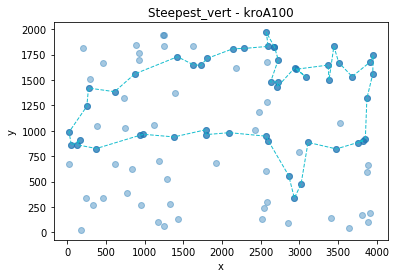

In [23]:
MIN = 100000
MAX = 0
SUM = 0
for i in range(1):
    x, out = random_path(50, 100)
    x = steepest_edge(x, out)
    x = np.append(x, x[0])
    len_x = path_length(x)
    
    if len_x > MAX:
        MAX = len_x
        MAX_path = x
    if len_x < MIN:
        MIN = len_x
        MIN_path = x
    SUM += len_x
print_plot(data, MIN_path, "Steepest_vert - kroA100", 'steepest_edge_kroA100')

In [22]:
print(MIN)
print(MAX)
print(SUM/100)

14217
14217
142.17
